In [39]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point, Polygon, box
import contextily as ctx
import rasterio
import numpy as np
from rasterio.plot import show as rioshow
import pyproj
import pandas as pd
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm

In [11]:
with xr.open_dataset('data/MERRA-2/merged.nc4') as ds:
    ds.load()
df = ds.to_dataframe()
df

SSSMASS25  DUSCATAU  BCSCATAU  DUEXTTAU   BCFLUXU  \
lat  lon     time                                                               
27.5 -97.500 2015-01-01  1.929910e-09  0.001560  0.002431  0.001664  0.000004   
             2015-01-02  1.398983e-09  0.001476  0.003116  0.001572  0.000006   
             2015-01-03  7.728337e-10  0.001717  0.002361  0.001830  0.000009   
             2015-01-04  9.810147e-10  0.005071  0.001328  0.005431  0.000006   
             2015-01-05  3.119860e-09  0.002209  0.001528  0.002350  0.000003   
...                               ...       ...       ...       ...       ...   
32.5 -91.875 2020-12-27  1.103539e-09  0.004158  0.001017  0.004435  0.000005   
             2020-12-28  1.144227e-09  0.005018  0.001723  0.005368  0.000007   
             2020-12-29  4.230147e-10  0.003823  0.001744  0.004084  0.000004   
             2020-12-30  2.255502e-09  0.001949  0.001303  0.002082  0.000006   
             2020-12-31  3.794760e-09  0.001723  0.002165  0.001838  0.000006   

                              OCFLUXV  BCANGSTR   SUFLUXV       SSSMASS  \
lat  lon     time                                                         
27.5 -97.500 2015-01-01  2.109124e-05  1.539294  0.000007  1.594830e-08   
             2015-01-02  5.719697e-05  1.497134  0.000081  6.315156e-09   
             2015-01-03  5.083041e-05  1.462451  0.000108  3.319087e-09   
             2015-01-04  9.259511e-06  1.428846 -0.000008  5.571303e-09   
             2015-01-05  1.278824e-05  1.458938  0.000008  2.227582e-08   
...                               ...       ...       ...           ...   
32.5 -91.875 2020-12-27  1.379185e-05  1.413061  0.000008  5.143933e-09   
             2020-12-28  6.057778e-07  1.455695  0.000003  5.762544e-09   
             2020-12-29  1.668398e-05  1.450341  0.000033  1.945764e-09   
             2020-12-30  3.856315e-05  1.450040  0.000039  1.237178e-08   
             2020-12-31  5.511900e-05  1.496634  0.000060  1.803924e-08   

                              OCSMASS  ...            SLP        TQV  \
lat  lon     time                      ...                             
27.5 -97.500 2015-01-01  1.090845e-09  ...  102362.734375  34.891560   
             2015-01-02  1.088885e-09  ...  101865.828125  33.353931   
             2015-01-03  1.363154e-09  ...  101606.859375  29.238062   
             2015-01-04  1.100944e-09  ...  102456.515625  11.435887   
             2015-01-05  5.114070e-10  ...  103517.070312  15.401300   
...                               ...  ...            ...        ...   
32.5 -91.875 2020-12-27  4.931962e-09  ...  101882.445312  10.195582   
             2020-12-28  1.469971e-09  ...  102224.921875  22.448105   
             2020-12-29  1.648802e-09  ...  102498.039062  19.456648   
             2020-12-30  1.568662e-09  ...  101746.492188  24.896044   
             2020-12-31  1.415541e-09  ...  101416.195312  34.190285   

                              V2M     TROPQ      V10M      U50M      U10M  \
lat  lon     time                                                           
27.5 -97.500 2015-01-01 -4.906837  0.000014 -6.401117 -1.040568 -0.583242   
             2015-01-02 -2.013163  0.000004 -2.569824  1.499022  1.378516   
             2015-01-03 -1.764241  0.000006 -2.303708  3.865480  3.092033   
             2015-01-04 -3.088592  0.000018 -4.104443  0.783023  0.458247   
             2015-01-05 -3.853312  0.000016 -5.023897 -2.091863 -1.499263   
...                           ...       ...       ...       ...       ...   
32.5 -91.875 2020-12-27  2.922699  0.000005  4.705240  1.296834  0.679608   
             2020-12-28  0.498021  0.000003  0.997802  2.126305  0.939887   
             2020-12-29  0.287038  0.000003  0.354689 -3.888931 -2.404750   
             2020-12-30  2.724511  0.000014  4.223238 -1.892775 -1.171457   
             2020-12-31 -2.022713  0.000013 -2.763136 -3.121873 -2.404983   

                             QV2M        TROPPV     QV10M  

In [3]:
# https://github.com/gboeing/ppd599/blob/3faf7e028d48cb03ddb999c5a910213c5384e7dc/17-Leaflet-Web-Mapping/leaflet-simple-demo/pandas-to-geojson.ipynb

def df_to_geojson(df, properties, lat='lat', lon='lon'):
    """
    Turn a dataframe containing point data into a geojson formatted python dictionary
    
    df : the dataframe to convert to geojson
    properties : a list of columns in the dataframe to turn into geojson feature properties
    lat : the name of the column in the dataframe that contains latitude data
    lon : the name of the column in the dataframe that contains longitude data
    """
    
    # create a new python dict to contain our geojson data, using geojson format
    geojson = {'type':'FeatureCollection', 'features':[]}

    # loop through each row in the dataframe and convert each row to geojson format
    for _, row in df.iterrows():
        # create a feature template to fill in
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}

        # fill in the coordinates
        feature['geometry']['coordinates'] = [row[lon],row[lat]]

        # for each column, get the value and add it as a new feature property
        for prop in properties:
            feature['properties'][prop] = row[prop]
        
        # add this feature (aka, converted dataframe row) to the list of features inside our dict
        geojson['features'].append(feature)
    
    return geojson



In [4]:
useful_columns = []
geojson_dict = df_to_geojson(df.reset_index(), properties=useful_columns)

In [12]:
df.loc[(27.5, -97.500, '2015-01-01')]

SSSMASS25    1.929910e-09
DUSCATAU     1.559505e-03
BCSCATAU     2.431344e-03
DUEXTTAU     1.664022e-03
BCFLUXU      3.722496e-06
                 ...     
U50M        -1.040568e+00
U10M        -5.832421e-01
QV2M         5.816119e-03
TROPPV       1.216775e+04
QV10M        5.654927e-03
Name: (27.5, -97.5, 2015-01-01 00:00:00), Length: 112, dtype: float32

In [ ]:
zip_path = f'zip://data/archived/houston_roads.zip!houston_roads/TRANSPORTATION_COMPLETE_STREETS.shp'
houston_roads = gpd.read_file(zip_path)

In [ ]:
south, west, north, east = (27.61,-97.38,32.75,-92.07)
_ = ctx.bounds2raster(west, south, east, north,
                     ll=True,
                     path="houston.tif",
                     source=ctx.providers.CartoDB.Positron
                    )

fig, ax = plt.subplots(figsize=(15,15))
with rasterio.open("houston.tif") as r:
    rioshow(r, ax=ax)

In [21]:
df.loc[(27.5, -97.500, '2015-01-01')]

SSSMASS25    1.929910e-09
DUSCATAU     1.559505e-03
BCSCATAU     2.431344e-03
DUEXTTAU     1.664022e-03
BCFLUXU      3.722496e-06
                 ...     
U50M        -1.040568e+00
U10M        -5.832421e-01
QV2M         5.816119e-03
TROPPV       1.216775e+04
QV10M        5.654927e-03
Name: (27.5, -97.5, 2015-01-01 00:00:00), Length: 112, dtype: float32

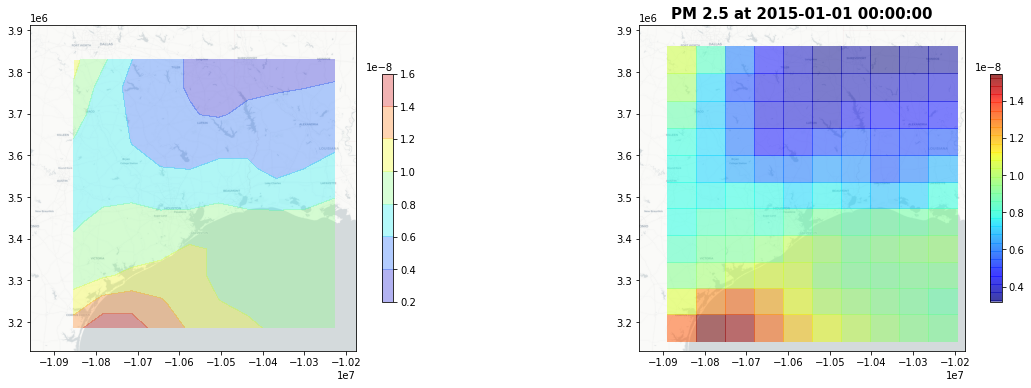

In [78]:
for name, group in df.groupby('time'):
    fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(20,6))
    
    group = group.reset_index()
    gdf = geopandas.GeoDataFrame(group, geometry=geopandas.points_from_xy(group.lon, group.lat), crs="EPSG:4326")
    gdf = gdf.to_crs(epsg=3857)
    
    gdf = gdf[['lat', 'lon', 'PM2.5']]
    lats = gdf.lat
    lons = gdf.lon
    
    transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:3857")
    lats_t, lons_t = transformer.transform(lats, lons)
    gdf.lat = lats_t
    gdf.lon = lons_t

    pivot = gdf.pivot('lon', 'lat')

    X=pivot.columns.levels[1].values
    Y=pivot.index.values
    Z=pivot.values

    Xi,Yi = np.meshgrid(X, Y)

    color1 = ax1.contourf(Xi, Yi, Z, alpha=0.3, cmap=plt.cm.jet)
    color2 = ax2.pcolor(Xi, Yi, Z, shading='auto', alpha=0.5, cmap=plt.cm.jet)

    fig.colorbar(color1, ax=ax1, shrink=.7)
    fig.colorbar(color2, ax=ax2, shrink=.7)

    ax1.set_aspect('equal', adjustable='box')
    ax2.set_aspect('equal', adjustable='box')
    
    plt.title(f'PM 2.5 at {name}', fontsize=15,fontweight='bold')
    with rasterio.open("houston.tif") as r:
        rioshow(r, ax=ax1)
        rioshow(r, ax=ax2)

    plt.show();
    break

In [37]:
df.reset_index(['lat', 'lon']).loc['2015']

,lat,lon,SSSMASS25,DUSCATAU,BCSCATAU,DUEXTTAU,BCFLUXU,OCFLUXV,BCANGSTR,SUFLUXV,...,SLP,TQV,V2M,TROPQ,V10M,U50M,U10M,QV2M,TROPPV,QV10M
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01,27.5,-97.500,1.929910e-09,0.001560,0.002431,0.001664,0.000004,0.000021,1.539294,0.000007,...,102362.734375,34.891560,-4.906837,0.000014,-6.401117,-1.040568,-0.583242,0.005816,12167.754883,0.005655
2015-01-02,27.5,-97.500,1.398983e-09,0.001476,0.003116,0.001572,0.000006,0.000057,1.497134,0.000081,...,101865.828125,33.353931,-2.013163,0.000004,-2.569824,1.499022,1.378516,0.006199,10776.143555,0.006056
2015-01-03,27.5,-97.500,7.728337e-10,0.001717,0.002361,0.001830,0.000009,0.000051,1.462451,0.000108,...,101606.859375,29.238062,-1.764241,0.000006,-2.303708,3.865480,3.092033,0.006609,11952.199219,0.006434
2015-01-04,27.5,-97.500,9.810147e-10,0.005071,0.001328,0.005431,0.000006,0.000009,1.428846,-0.000008,...,102456.515625,11.435887,-3.088592,0.000018,-4.104443,0.783023,0.458247,0.005969,13455.602539,0.005817
2015-01-05,27.5,-97.500,3.119860e-09,0.002209,0.001528,0.002350,0.000003,0.000013,1.458938,0.000008,...,103517.070312,15.401300,-3.853312,0.000016,-5.023897,-2.091863,-1.499263,0.004544,12372.834961,0.004360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,32.5,-91.875,6.072193e-09,0.001163,0.001081,0.001234,0.000003,0.000031,1.467872,0.000055,...,101026.289062,35.665401,3.272929,0.000023,4.998493,-3.055818,-2.063844,0.015406,13043.234375,0.015315
2015-12-28,32.5,-91.875,4.965197e-09,0.003855,0.001408,0.004133,0.000008,0.000054,1.437381,0.000111,...,100420.343750,27.682411,4.524295,0.000004,6.678102,1.832380,1.400568,0.010327,9978.894531,0.010126
2015-12-29,32.5,-91.875,2.291771e-10,0.002060,0.001508,0.002197,0.000007,0.000025,1.438725,0.000026,...,101749.859375,13.344791,-0.121014,0.000003,-0.313511,1.768249,0.716151,0.004945,10343.920898,0.004790


In [40]:
def ridgeline(data, overlap=0, fill=True, labels=None, n_points=150):
    """
    Creates a standard ridgeline plot.

    data, list of lists.
    overlap, overlap between distributions. 1 max overlap, 0 no overlap.
    fill, matplotlib color to fill the distributions.
    n_points, number of points to evaluate each distribution function.
    labels, values to place on the y axis to describe the distributions.
    """
    if overlap > 1 or overlap < 0:
        raise ValueError('overlap must be in [0 1]')
    xx = np.linspace(np.min(np.concatenate(data)),
                     np.max(np.concatenate(data)), n_points)
    curves = []
    ys = []
    for i, d in enumerate(data):
        pdf = gaussian_kde(d)
        y = i*(1.0-overlap)
        ys.append(y)
        curve = pdf(xx)
        if fill:
            plt.fill_between(xx, np.ones(n_points)*y, 
                             curve+y, zorder=len(data)-i+1, color=fill)
        plt.plot(xx, curve+y, c='k', zorder=len(data)-i+1)
    if labels:
        plt.yticks(ys, labels)

In [41]:
_df = df.reset_index()
_df['Date'] = _df['time'].dt.date
_df['year'] = _df.time.dt.year
_df = _df.drop(['time'], axis=1)

_df = _df.set_index(['lat', 'lon', 'year'])
m = _df.groupby(['lat', 'lon', 'year']).mean()

averaged = m.reset_index()[['year', 'PM2.5']]
averaged

,year,PM2.5
0,2015,1.734326e-08
1,2016,1.492275e-08
2,2017,1.547298e-08
3,2018,1.653211e-08
4,2019,1.641274e-08
...,...,...
655,2016,1.258541e-08
656,2017,1.356965e-08
657,2018,1.411955e-08
658,2019,1.337824e-08


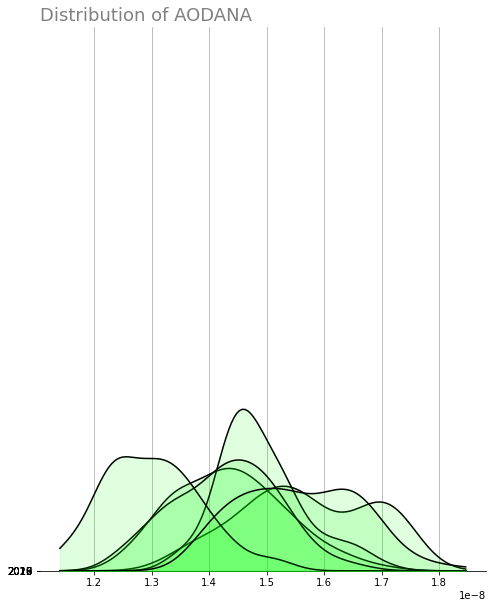

In [69]:
fig, ax = plt.subplots(figsize=(8, 10))

grouped = [(y, g['PM2.5'].values) for y, g in averaged.groupby('year')]
years, data = zip(*grouped)

ridgeline(data, labels=years, overlap=.01, fill='#00ff0020')
plt.title('Distribution of AODANA',
          loc='left', fontsize=18, color='gray')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlabel('ppm')
# ax.set_xlim((co2_data.ppm.min(), co2_data.ppm.max()))
ax.set_ylim((0, 2000000000.1))
plt.grid(zorder=0)
plt.show()

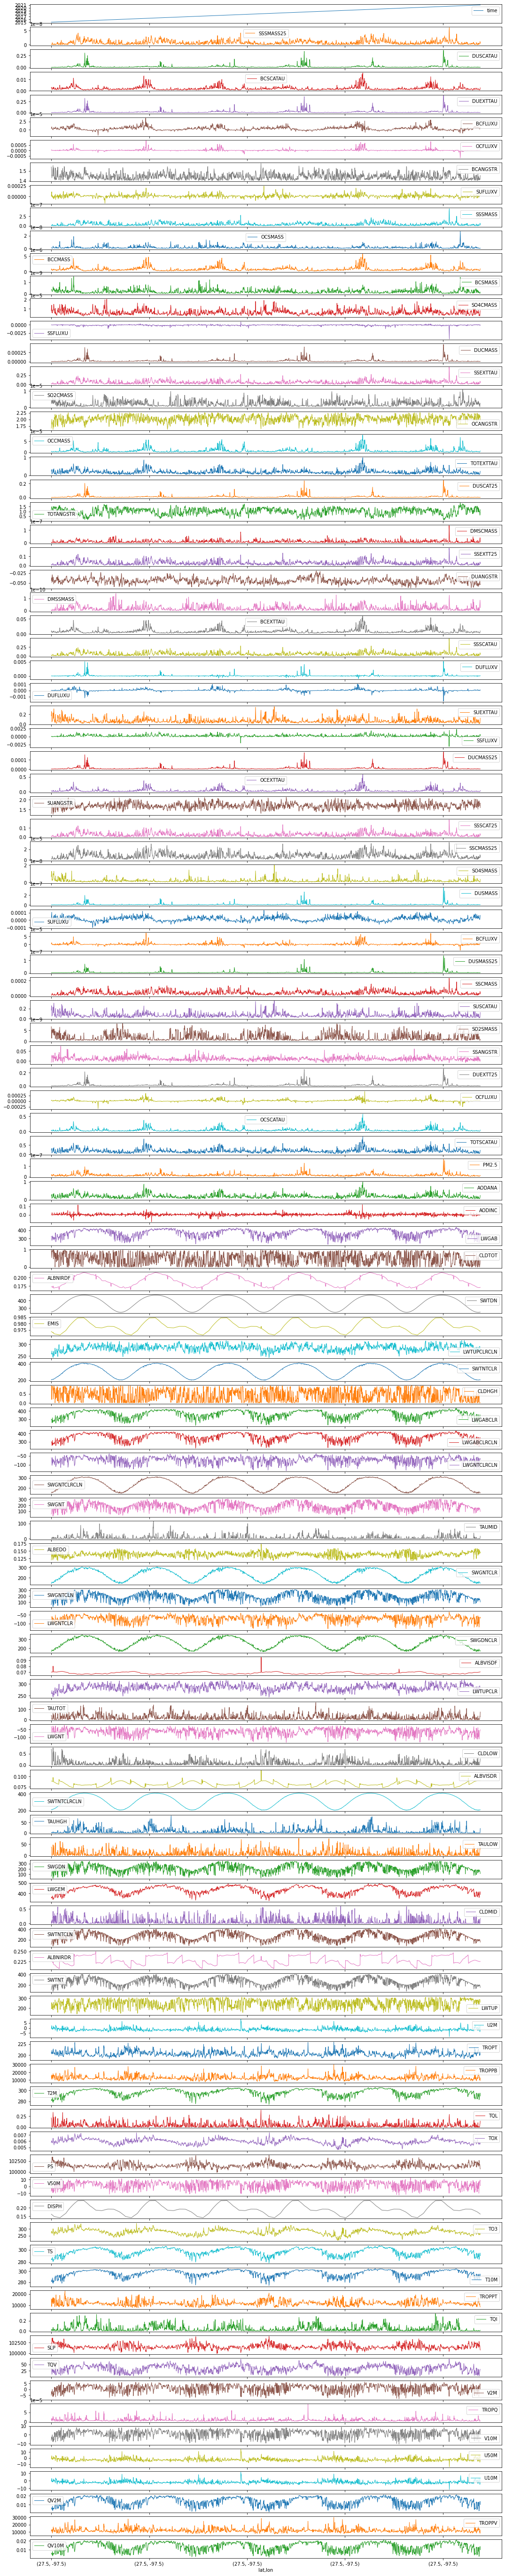

In [76]:
df.reset_index(['time']).loc[27.5, -97.500].plot(subplots=True, figsize=(18, 100), lw=1);